In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisqprob, chi2,chi2_contingency
import statsmodels.api as sm
from statsmodels.tools import add_constant as add_constant
import seaborn as sn
import sklearn
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from imblearn.under_sampling import NearMiss
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve

In [40]:
heart_df=pd.read_csv("CHD_data.csv")
heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [41]:
heart_df.loc[ pd.isnull(heart_df.cigsPerDay) & (heart_df.TenYearCHD==1),'cigsPerDay'] = heart_df.loc[heart_df['TenYearCHD'] == 1]['cigsPerDay'].max()

heart_df.loc[ pd.isnull(heart_df.cigsPerDay) & (heart_df.TenYearCHD==0),'cigsPerDay'] = heart_df.loc[heart_df['TenYearCHD'] == 0]['cigsPerDay'].min()


heart_df.loc[ pd.isnull(heart_df.totChol) & (heart_df.TenYearCHD==1),'totChol'] = heart_df.loc[heart_df['TenYearCHD'] == 1]['totChol'].max()

heart_df.loc[ pd.isnull(heart_df.totChol) & (heart_df.TenYearCHD==0),'totChol'] = heart_df.loc[heart_df['TenYearCHD'] == 0]['totChol'].min()


heart_df.loc[ pd.isnull(heart_df.glucose) & (heart_df.TenYearCHD==1),'glucose'] = heart_df.loc[heart_df['TenYearCHD'] == 1]['glucose'].max()

heart_df.loc[ pd.isnull(heart_df.glucose) & (heart_df.TenYearCHD==0),'glucose'] = heart_df.loc[heart_df['TenYearCHD'] == 0]['glucose'].min()


heart_df.loc[ pd.isnull(heart_df.heartRate) & (heart_df.TenYearCHD==1),'heartRate'] = heart_df.loc[heart_df['TenYearCHD'] == 1]['heartRate'].max()

heart_df.loc[ pd.isnull(heart_df.heartRate) & (heart_df.TenYearCHD==0),'heartRate'] = heart_df.loc[heart_df['TenYearCHD'] == 0]['heartRate'].min()

In [42]:
chd_df = heart_df.copy()

In [43]:
#Data pre-processing
#1) Check data quality issues - missing values
count=0
for i in heart_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Missing values: ' + str(count)  + ' out of ' +  str(len(heart_df)))
# remove the missing records
heart_df.dropna(axis=0,inplace=True)

Missing values: 176 out of 4240


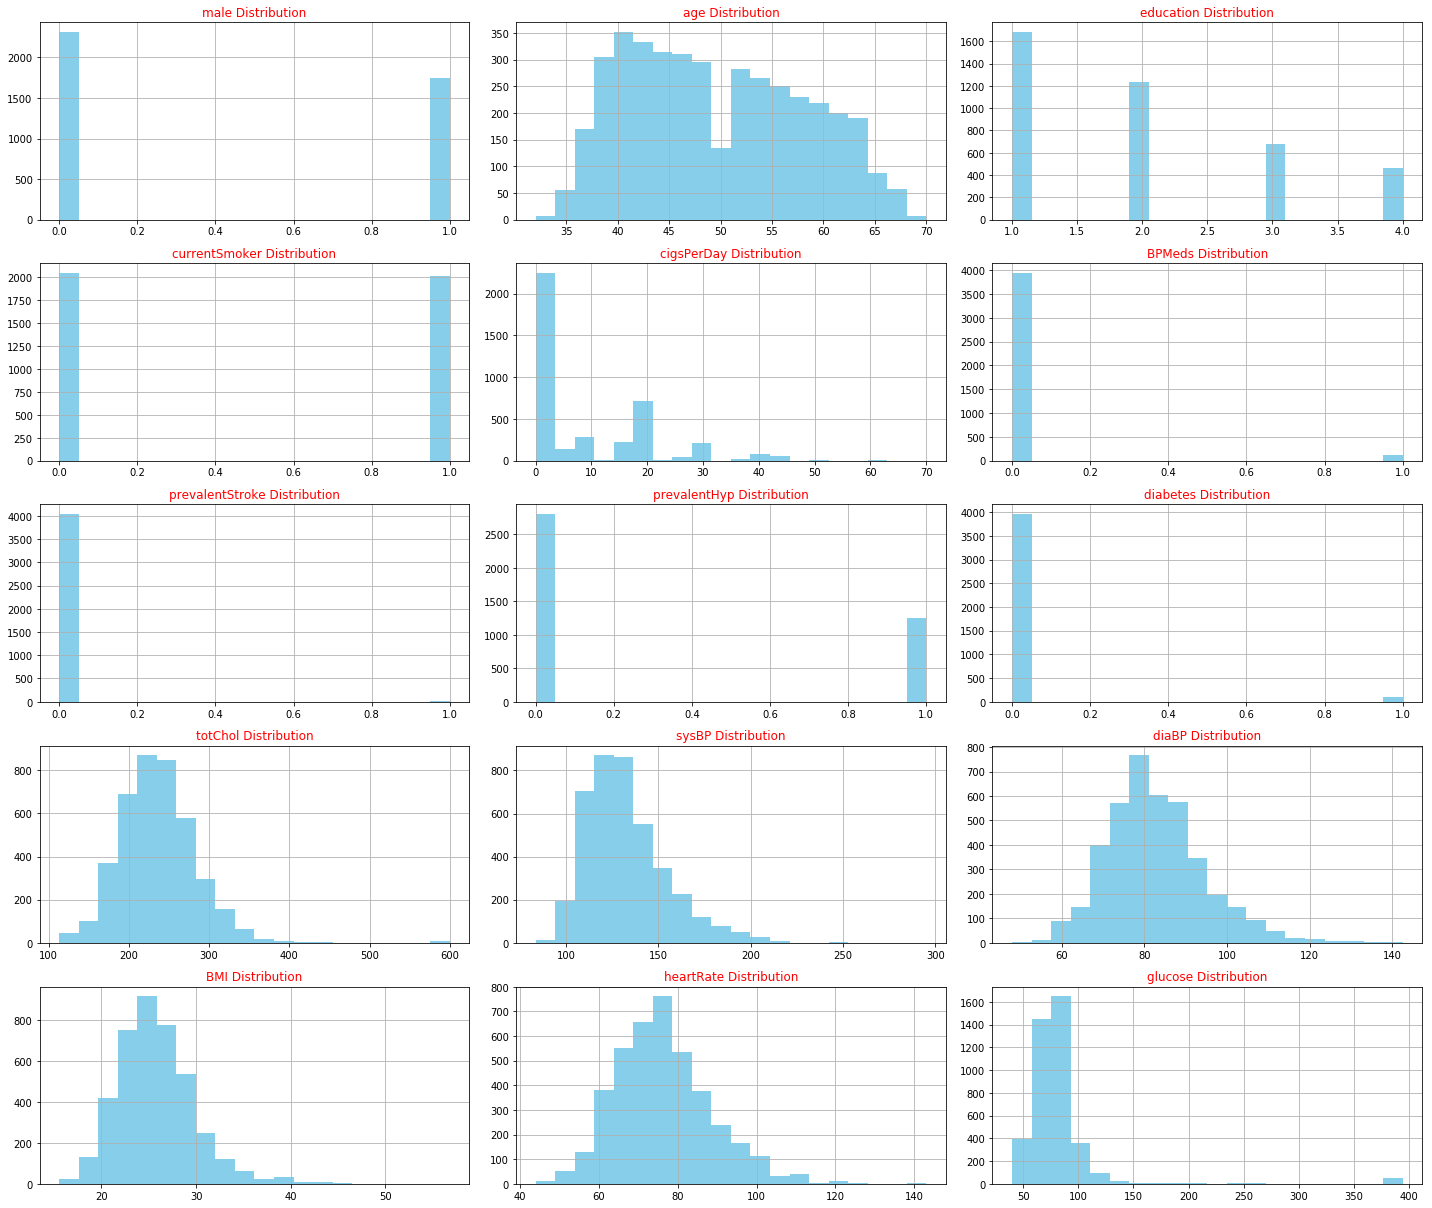

In [44]:
#data distribution analysis
def plot_hist(df, columns, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, col in enumerate(columns):
        if(col != 'TenYearCHD'):
            ax=fig.add_subplot(rows,cols,i+1)
            df[col].hist(bins=20,ax=ax,facecolor='skyblue')
            ax.set_title(col+" Distribution",color='red')
    fig.tight_layout()  
    plt.show()
plot_hist(heart_df,heart_df.columns,6,3)

In [45]:
#categorical and quantitative features
df_cat=heart_df[['education','male','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes',
                 'TenYearCHD']]
df_numeric = heart_df[['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate',
                 'glucose']]

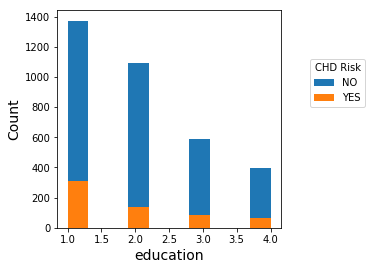

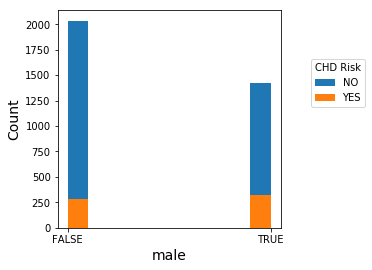

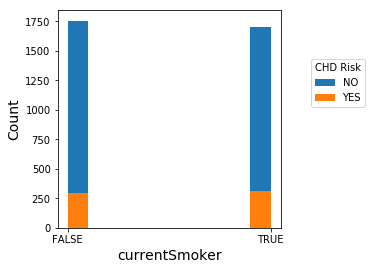

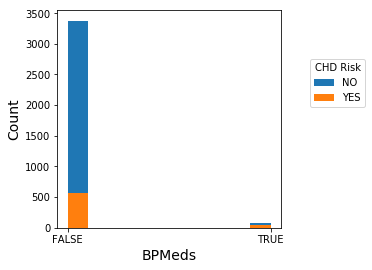

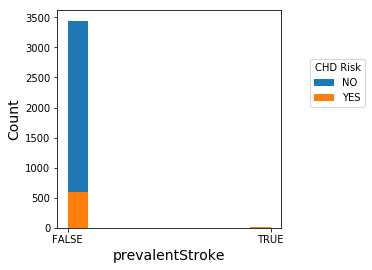

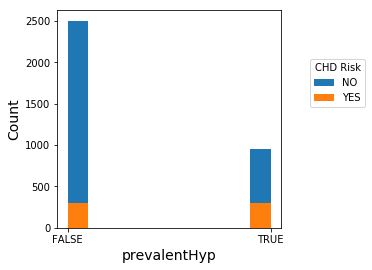

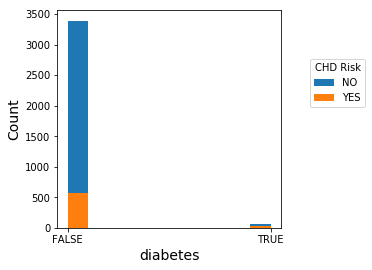

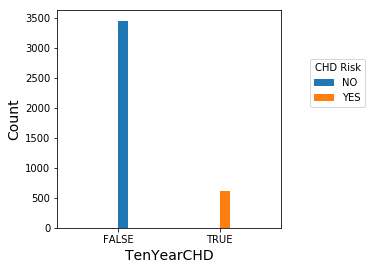

In [46]:
#Stacked histogram for categorical attributes
def draw_bivar_plots_cat(dataframe, features, rows, cols):
    colors = ['tan', 'lime']
    for feature in features:
        dataframe[feature].groupby(dataframe['TenYearCHD']).plot(kind='hist',figsize=(4,4))
        plt.xlabel(feature, fontsize=14)
        if(feature != 'education'):
            plt.xticks([0,1], ['FALSE','TRUE'])
        plt.ylabel('Count', fontsize=14)
        plt.legend(["NO", "YES"], title="CHD Risk",loc='best', bbox_to_anchor=(0.6, 0., 0.8, 0.8))
        plt.show()
    
draw_bivar_plots_cat(heart_df,df_cat.columns,6,3)

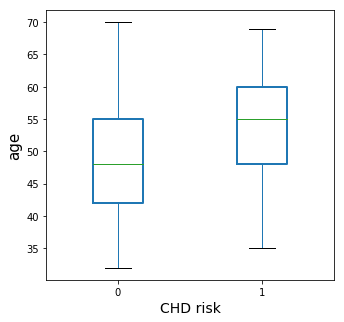

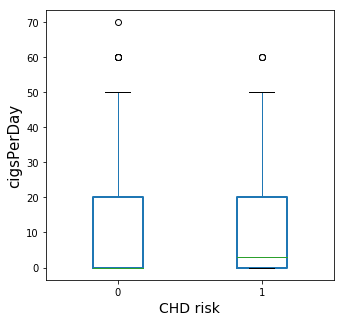

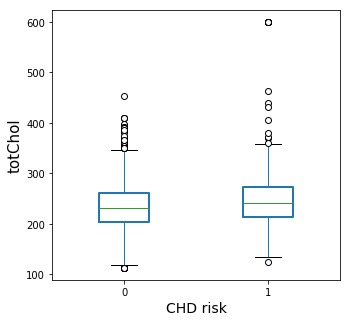

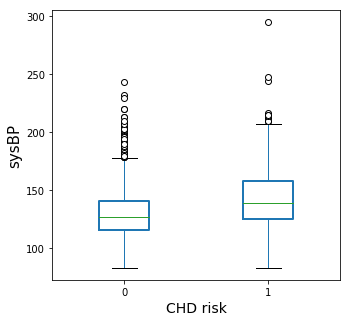

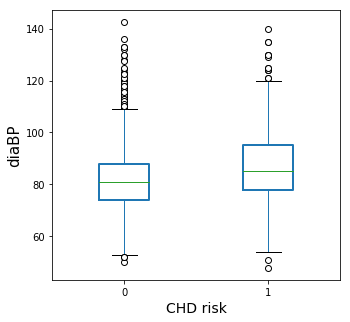

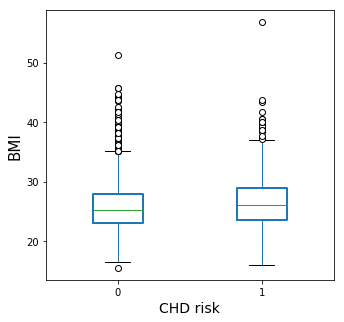

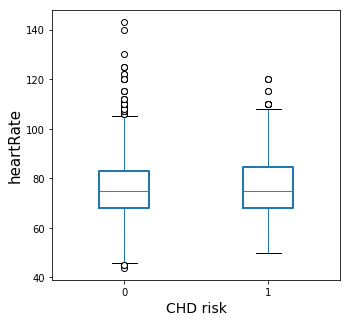

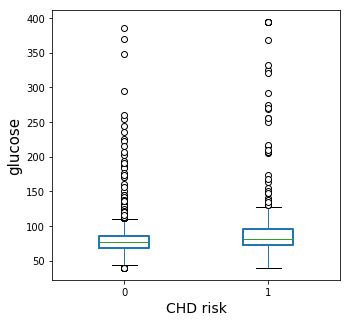

In [47]:
#Boxplots for quantitative attributes
def draw_bivar_plots_quant(dataframe, features, rows, cols):

    fig=plt.figure(figsize=(7,7),facecolor="white")
    boxprops = dict( linewidth=2, color='darkgoldenrod')
    meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
    red_square = dict(markerfacecolor='white', marker='o')
    for feature in features:
        dataframe.boxplot(column = feature, by ='TenYearCHD',grid = False,
                          meanline=True,widths=0.35,meanprops=meanlineprops, boxprops=boxprops,flierprops=red_square, figsize=(5,5))
        plt.xlabel('CHD risk', fontsize=14)
        plt.ylabel(feature, fontsize=15)
        plt.legend()
        plt.title('')
        plt.suptitle("")
        plt.show()
    
draw_bivar_plots_quant(heart_df,df_numeric.columns,6,3)


In [48]:
heart_df_constant = add_constant(heart_df)
chisqprob = lambda chisq, df: chi2.sf(chisq, df)
cols=heart_df_constant.columns[:-1]
model=sm.Logit(heart_df.TenYearCHD,heart_df_constant[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.349051
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4064
Model:                          Logit   Df Residuals:                     4048
Method:                           MLE   Df Model:                           15
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:                  0.1721
Time:                        22:08:49   Log-Likelihood:                -1418.5
converged:                       True   LL-Null:                       -1713.4
                                        LLR p-value:                5.588e-116
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -9.1522      0.707    -12.952      0.000     -10.537      -7.767
male                0.5769      0.108      5.355      0.000       0.366       0.788
age                 0.0632      0.007      9.496      0.000       0.050       0.076
education          -0.0393      0.049     -0.800      0.424      -0.135       0.057
currentSmoker      -0.0129      0.153     -0.084      0.933      -0.313       0.287
cigsPerDay          0.0224      0.006      3.734      0.000       0.011       0.034
BPMeds              0.2153      0.234      0.920      0.358      -0.243       0.674
prevalentStroke     0.7147      0.490      1.460      0.144      -0.245       1.674
prevalentHyp        0.2352      0.137      1.714      0.086      -0.034       0.504
diabetes           -0.7151      0.300     -2.384      0.017      -1.303      -0.127
totChol             0.0032      0.001      2.992      0.003       0.001       0.005
sysBP               0.0148      0.004      3.919      0.000       0.007       0.022
diaBP              -0.0038      0.006     -0.601      0.548      -0.016       0.009
BMI                 0.0070      0.013      0.553      0.580      -0.018       0.032
heartRate          -0.0046      0.004     -1.110      0.267      -0.013       0.004
glucose             0.0158      0.002      9.795      0.000       0.013       0.019
===================================================================================
"""

In [49]:
#backward feature elimination
def select_features(data_frame,dep_var,col_list):
    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=(result.pvalues).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=select_features(heart_df_constant,heart_df.TenYearCHD,cols)

In [50]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4064
Model:                          Logit   Df Residuals:                     4056
Method:                           MLE   Df Model:                            7
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:                  0.1694
Time:                        22:08:52   Log-Likelihood:                -1423.1
converged:                       True   LL-Null:                       -1713.4
                                        LLR p-value:                3.935e-121
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.0332      0.478    -20.973      0.000     -10.971      -9.096
male           0.5888      0.106      5.579      0.000       0.382       0.796
age            0.0657      0.006     10.276      0.000       0.053       0.078
cigsPerDay     0.0210      0.004      5.146      0.000       0.013       0.029
diabetes      -0.6847      0.297     -2.305      0.021      -1.267      -0.102
totChol        0.0031      0.001      2.974      0.003       0.001       0.005
sysBP          0.0171      0.002      7.991      0.000       0.013       0.021
glucose        0.0157      0.002      9.739      0.000       0.013       0.019
==============================================================================
"""

In [51]:
# train the model using only the selected features
new_features=chd_df[['age','male','cigsPerDay','totChol','sysBP','glucose','heartRate','diabetes','TenYearCHD']]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [52]:
#define models for ensemble
kfold = StratifiedKFold(n_splits=5, shuffle=True) 
estimators = []
model1 = LogisticRegression(C=1, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=48,
          solver='sag', tol=0.0001, verbose=0, warm_start=True)
smote_pipe1 = make_imb_pipeline(StandardScaler(), model1)
estimators.append(('logistic', smote_pipe1))

model2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_leaf_nodes=None,
            max_features=5,                    
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=False, random_state=48, verbose=0,
            warm_start=True)
smote_pipe2 = make_imb_pipeline(StandardScaler(), SMOTEENN(smote=SMOTE(k_neighbors=7)), model2)
estimators.append(('cart', smote_pipe2))

model3 = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=3,
    max_depth=9,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=48,
    min_samples_leaf=2)
smote_pipe3 = make_imb_pipeline(StandardScaler(), model3)
estimators.append(('mgbclp', smote_pipe3))

In [53]:
#resampling training data
X_full = x_train.copy()
X_full['target'] = y_train
X_maj = X_full[X_full.target==0]
X_min = X_full[X_full.target==1]
X_maj_rus = resample(X_maj,replace=False,n_samples=len(X_min),random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop(['target'], axis=1)
y_train_rus = X_rus.target

In [54]:
# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft')            
ensemble.fit(X_train_rus, y_train_rus)
y_pred=ensemble.predict(x_test)
print('Accuracy:',sklearn.metrics.accuracy_score(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(metrics.classification_report(y_test,y_pred))

('Accuracy:', 0.74056603773584906)
             precision    recall  f1-score   support

          0       0.94      0.74      0.83       715
          1       0.35      0.73      0.47       133

avg / total       0.84      0.74      0.77       848



             precision    recall  f1-score   support

          0       0.00      0.00      0.00       715
          1       0.16      1.00      0.27       133

avg / total       0.02      0.16      0.04       848

('Accuracy:', 0.74056603773584906)
('With', 0, 'threshold the Confusion Matrix is ', '\n', array([[  0, 715],
       [  0, 133]]), '\n', 'with', 133, 'correct predictions and', 0, 'Type II errors( False Negatives)', '\n\n', 'Sensitivity: ', 1.0, 'Specificity: ', 0.0, '\n\n\n')


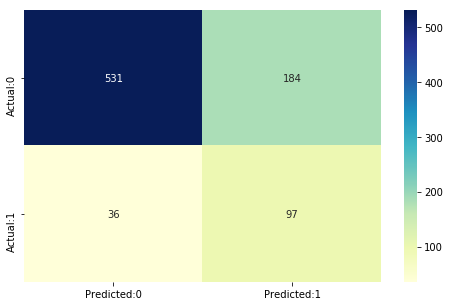

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       715
          1       0.16      1.00      0.27       133

avg / total       0.02      0.16      0.04       848

('Accuracy:', 0.74056603773584906)
('With', 0, 'threshold the Confusion Matrix is ', '\n', array([[  0, 715],
       [  0, 133]]), '\n', 'with', 133, 'correct predictions and', 0, 'Type II errors( False Negatives)', '\n\n', 'Sensitivity: ', 1.0, 'Specificity: ', 0.0, '\n\n\n')
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       715
          1       0.16      1.00      0.27       133

avg / total       0.02      0.16      0.04       848

('Accuracy:', 0.74056603773584906)
('With', 0, 'threshold the Confusion Matrix is ', '\n', array([[  0, 715],
       [  0, 133]]), '\n', 'with', 133, 'correct predictions and', 0, 'Type II errors( False Negatives)', '\n\n', 'Sensitivity: ', 1.0, 'Specificity: ', 0.0, '\n\n\n')
             p

In [55]:
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=ensemble.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print(metrics.classification_report(y_test,y_pred2))
    print('Accuracy:',sklearn.metrics.accuracy_score(y_test,y_pred))
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')
    plt.show()

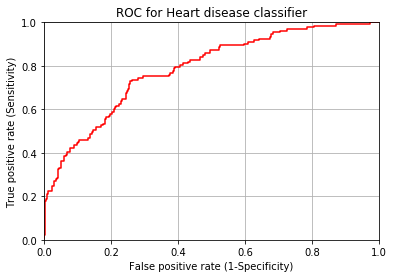

Area under the curve:


0.79

In [59]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr, color = 'r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()
#Area Under The Curve (AUC)
print('Area under the curve:')
round(sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1]),2)